:
# Training a Tiny VGG on MNIST

This notebook demonstrates how to build and train a simple Convolutional Neural Network (CNN) on the MNIST dataset.
We will visualize the dataset, understand the architecture of the network, and analyze the results step by step.

### Objectives:
1. Understand the MNIST dataset and visualize some images.
2. Build a simple CNN architecture.
3. Train the CNN and monitor its performance.
4. Visualize intermediate outputs and performance metrics.


In [27]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load the MNIST Dataset

In [28]:
dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

In [29]:
dataset, type(dataset)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

In [30]:
len(dataset), len(test_dataset)

(60000, 10000)

In [31]:
class_names = dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Create the DataLoader

##### Split training dataset into training and validation

In [32]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [33]:
len(train_dataset), len(val_dataset), len(test_dataset)

(48000, 12000, 10000)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

example_data.shape, example_targets.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## Visualizing some MNIST images

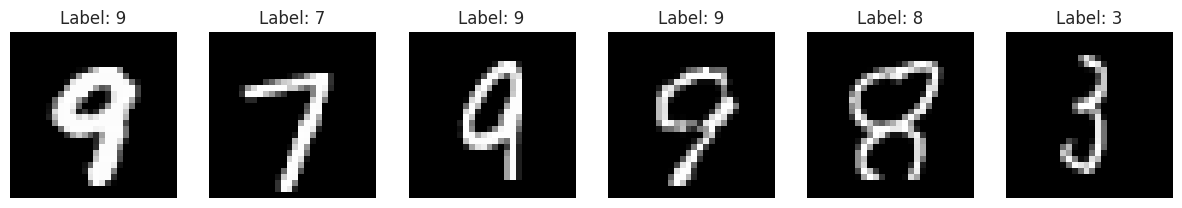

In [36]:

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    axes[i].imshow(example_data[i][0], cmap='gray')
    axes[i].set_title(f"Label: {example_targets[i].item()}")
    axes[i].axis('off')
plt.show()


## label distribution from a dataset

In [37]:
def get_label_distribution(dataset):
    label_count = {}
    for _, target in dataset:
        label = int(target)
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1
    return label_count

train_label_count = get_label_distribution(train_loader.dataset)
test_label_count = get_label_distribution(test_loader.dataset)
val_label_count = get_label_distribution(val_loader.dataset)

In [38]:
dict(sorted(train_label_count.items()))

{0: 4710,
 1: 5397,
 2: 4769,
 3: 4953,
 4: 4704,
 5: 4317,
 6: 4747,
 7: 4965,
 8: 4655,
 9: 4783}

In [39]:
dict(sorted(test_label_count.items()))

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [40]:
dict(sorted(val_label_count.items()))

{0: 1213,
 1: 1345,
 2: 1189,
 3: 1178,
 4: 1138,
 5: 1104,
 6: 1171,
 7: 1300,
 8: 1196,
 9: 1166}

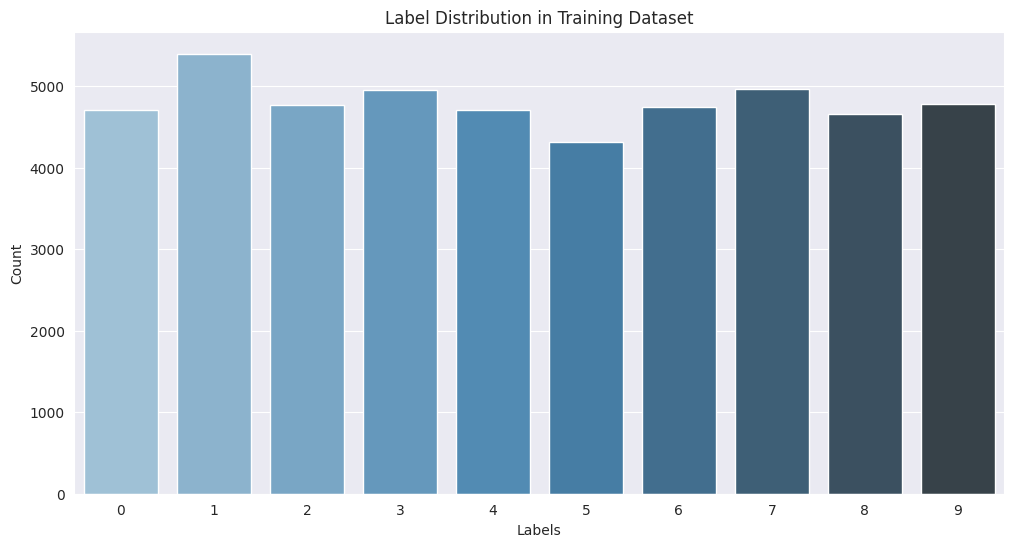

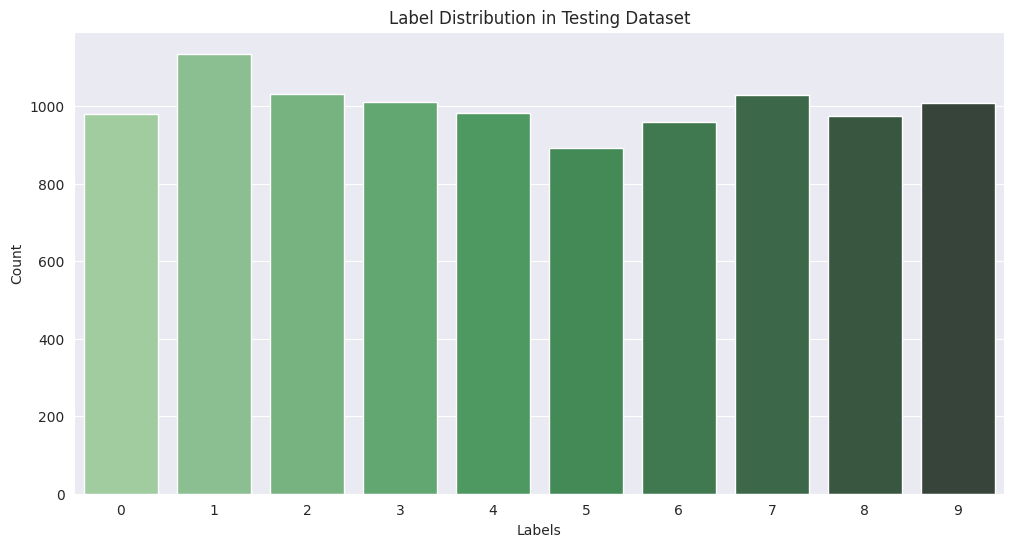

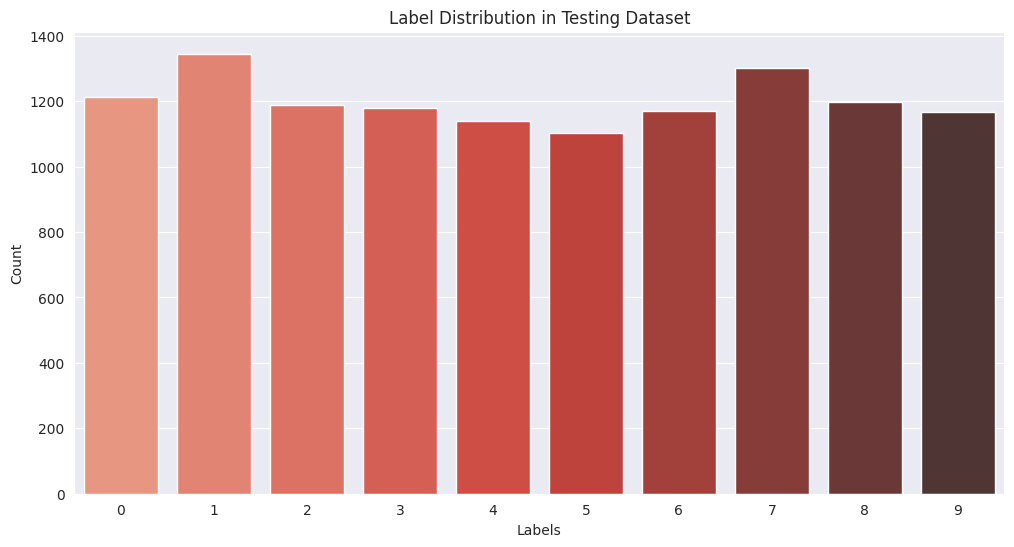

In [41]:
# Train dataset
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=list(train_label_count.keys()), y=list(train_label_count.values()), palette="Blues_d")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in Training Dataset')
plt.show()
    
# Test dataset
plt.figure(figsize=(12, 6))
sns.barplot(x=list(test_label_count.keys()), y=list(test_label_count.values()), palette="Greens_d")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in Testing Dataset')
plt.show()

# Val dataset
plt.figure(figsize=(12, 6))
sns.barplot(x=list(val_label_count.keys()), y=list(val_label_count.values()), palette="Reds_d")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in Testing Dataset')
plt.show()

## Model Implementation


$$
 \text{Output size} = \left\lfloor \frac{{\text{Input size} - \text{Filter size} + 2 \times \text{Padding}}}{{\text{Stride}}} + 1 \right\rfloor
 $$
Input size: Size of the input image.<br>
Filter size: Size of the convolutional filter.<br>
Padding: Additional pixels added around the input image to ensure that the filter can be applied to the edges.<br>
Stride: Number of pixels the filter moves after each convolution operation.<br>


In [42]:
class TinyVGG(nn.Module):
    def __init__(self, in_channel: int, hidden_units: int, n_classes: int):
        super(TinyVGG, self).__init__()

        # Convolutional block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: (batch_size, hidden_units, 28, 28)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: (batch_size, hidden_units, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, hidden_units, 14, 14)
        )

        # Convolutional block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: (batch_size, hidden_units, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Output: (batch_size, hidden_units, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, hidden_units, 7, 7)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=n_classes)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


# Instantiate the model, loss function, and optimizer
model = TinyVGG(in_channel=1,
                  hidden_units=10,
                  n_classes=10
                  ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.01)


In [43]:
num_epochs = 5
train_losses = []
train_accuracies = []
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    data_loader = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        data_loader.set_postfix(loss=running_loss / len(train_loader), accuracy=f"{(100.0 * correct / total):.2f}%")

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100.0 * correct / total)
    
    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100.0 * val_correct / val_total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_mnist_checkpoint.pth")
        print("Best model saved.")


Epoch 1/5: 100%|██████████| 750/750 [00:15<00:00, 48.14it/s, accuracy=93.71%, loss=0.199] 


Validation Accuracy: 97.66%
Best model saved.


Epoch 2/5: 100%|██████████| 750/750 [00:22<00:00, 33.42it/s, accuracy=97.38%, loss=0.0854]


Validation Accuracy: 98.01%
Best model saved.


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 35.81it/s, accuracy=97.88%, loss=0.0674] 


Validation Accuracy: 97.54%


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.09it/s, accuracy=97.96%, loss=0.0653] 


Validation Accuracy: 97.78%


Epoch 5/5: 100%|██████████| 750/750 [00:22<00:00, 33.61it/s, accuracy=98.23%, loss=0.0586] 


Validation Accuracy: 98.08%
Best model saved.


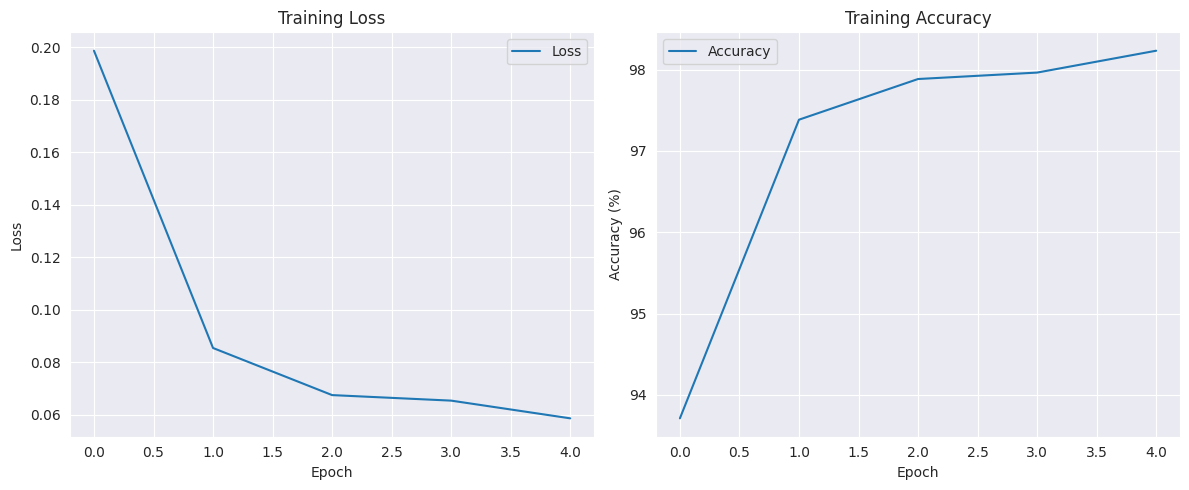

In [44]:

# Plot training loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_losses, label='Loss')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_accuracies, label='Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

plt.tight_layout()
plt.show()


In [45]:

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.0 * correct / total:.2f}%")


Test Accuracy: 98.31%


In [46]:
type(outputs), outputs.shape, outputs.max(1), labels

(torch.Tensor,
 torch.Size([16, 10]),
 torch.return_types.max(
 values=tensor([ 7.2014, 11.7246, 13.0221, 16.3413, 18.7868, 11.6993, 15.5051, 12.3329,
         13.8872, 10.5247,  8.5123, 18.1239, 13.6467, 14.0129, 14.6883, 12.2563],
        device='cuda:0'),
 indices=tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')),
 tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0'))

In [47]:
model.conv_block_1

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

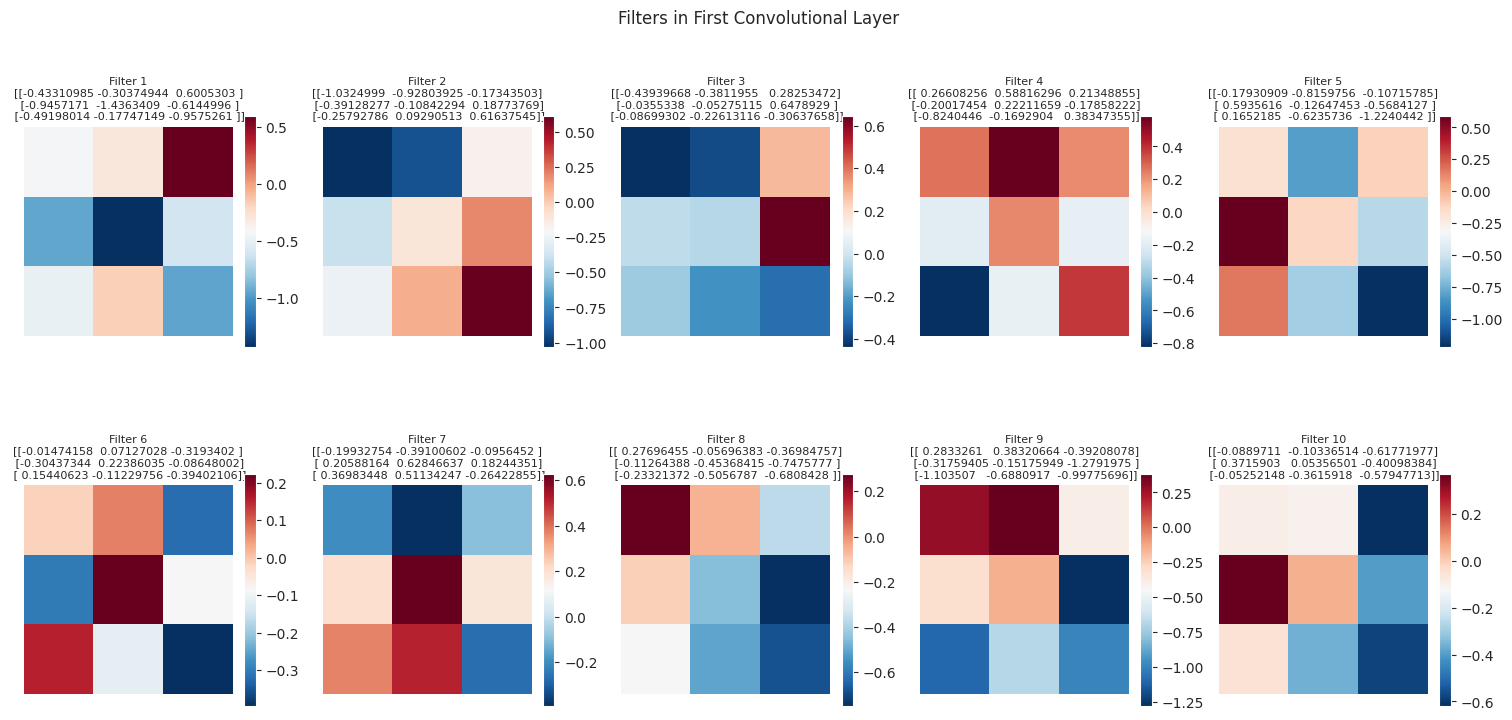

In [48]:
weights = model.conv_block_1[0].weight.data.cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    if i < weights.shape[0]:
        im = ax.imshow(weights[i, 0], cmap='RdBu_r')
        ax.set_title(f'Filter {i+1}\n{weights[i, 0]}', fontsize=8)  # Displaying the weight values on the filters
        ax.axis('off')

        # Add a color bar
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05)

plt.suptitle('Filters in First Convolutional Layer')
plt.tight_layout()
plt.show()